# Práctica 2 (Clasificador de crímenes)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import _tree
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

### Justificación del clasificador seleccionado

Para resolver la tarea de clasificación propuesta en esta práctica, se ha elegido utilizar un **árbol de decisión** (`DecisionTreeClassifier`) como modelo principal.

Este clasificador se considera el más adecuado para este problema por las siguientes razones:

1. **Generación automática de reglas**  
   Un árbol de decisión permite **extraer reglas de forma explícita** a partir de los datos. Dado que el enunciado solicita obtener una **serie de reglas** que expliquen qué tipo de crimen puede ocurrir según el momento del día, el día de la semana y el distrito, este modelo es especialmente apropiado.

2. **Interpretabilidad y visualización**  
   Los árboles de decisión son fácilmente **interpretables** y se pueden representar gráficamente, lo que facilita entender el razonamiento detrás de cada predicción. Esto encaja con la necesidad de **dibujar el modelo** (punto 2) y **seleccionar reglas que generalicen o especialicen** (punto 3).

3. **Manejo de variables categóricas**  
   El árbol puede manejar de forma directa variables categóricas como el **día de la semana** o el **distrito**, especialmente si se transforman adecuadamente mediante codificación (como one-hot encoding o label encoding).

4. **Evaluación con distintos criterios de división**  
   Otra ventaja del árbol es que permite comparar fácilmente **diferentes criterios de partición**, como el **índice de Gini** y la **entropía**, lo cual es precisamente lo que solicita el punto 1 de la práctica. Esto permite construir dos modelos con el mismo algoritmo cambiando solo el criterio de división, facilitando la comparación del error en cada caso.

5. **Eficiencia y rapidez**  
   Para datasets de tamaño medio como `sf_crimenes.csv`, los árboles de decisión permiten un entrenamiento y predicción **rápidos**, lo cual es adecuado para un entorno de prácticas académicas.

En conclusión, el **árbol de decisión** ofrece una solución precisa, transparente y didáctica para resolver el problema de clasificación de crímenes en San Francisco, cumpliendo todos los requisitos técnicos y pedagógicos del enunciado.


### Preprocesamiento

Siguiendo las recomendaciones vistas en clase, se ha aplicado el **principio de Pareto** para realizar una división equilibrada y eficiente de los datos del dataset `sf_crimenes.csv`.

La distribución se ha realizado en dos etapas:

1. **Primera división (entrenamiento y prueba):**
   - **80%** del total de los datos se ha reservado para **entrenamiento y validación**.
   - **20%** restante se ha reservado como **conjunto de prueba final (test)**, que no se utilizará hasta el último apartado de la práctica.

2. **Segunda división interna del entrenamiento (dentro del 80%):**
   - **80%** de ese subconjunto se ha destinado al **entrenamiento** del modelo.
   - **20%** restante se ha usado como **conjunto de validación** para evaluar el modelo antes de aplicarlo a datos no vistos.

#### Distribución final sobre los 3000 registros del dataset:

| Conjunto        | Porcentaje | Cantidad de ejemplos |
|-----------------|------------|-----------------------|
| Entrenamiento   | 64%        | 1920                  |
| Validación      | 16%        | 480                   |
| Prueba (Test)   | 20%        | 600                   |
| **Total**       | 100%       | 3000                  |



### ¿Qué hace el código para aplicar esta división?

1. **Carga y preparación del dataset**  
   Se importa el archivo `sf_crimenes.csv` y se convierte la columna `Dates` al formato `datetime`. Luego, se extrae la **hora** de cada crimen para clasificarlo según el `MomentoDia` (Noche, Mañana o Tarde). Las filas con fechas no válidas se eliminan para garantizar la integridad del análisis.

2. **Selección y transformación de variables**  
   Se escogen tres atributos: `MomentoDia`, `DayOfWeek` y `PdDistrict`, que junto con la variable objetivo `Category` permiten predecir el tipo de crimen. Como estas variables son categóricas, se codifican usando **One-Hot Encoding** para que puedan ser interpretadas por los modelos de `scikit-learn`.

3. **División según el principio de Pareto**  
   - Primero se separa el **20% del total como conjunto de prueba (`X_test`, `y_test`)**, que no se usará hasta la evaluación final.
   - Luego, el **80% restante se divide en dos partes internas**:
     - **80% para entrenamiento (`X_train`, `y_train`)**
     - **20% para validación (`X_val`, `y_val`)**

Esta división asegura que el modelo se entrene con la mayoría de los datos, se valide con un subconjunto no visto, y finalmente se pruebe con un conjunto completamente independiente, imitando el uso real en producción.


In [13]:
# Aplicamos el principio de Pareto de forma explícita según la imagen: 
# 1. 80% datos para entrenamiento (que internamente se dividirá en 80% entrenamiento y 20% validación)
# 2. 20% datos para prueba final

# Cargar el dataset desde un archivo CSV
df = pd.read_csv('sf_crimenes.csv')

# Convertir la fecha y extraer el momento del día
df['Dates'] = pd.to_datetime(df['Dates'], errors='coerce')
df = df.dropna(subset=['Dates'])

df['MomentoDia'] = df['Dates'].dt.hour.apply(
    lambda h: 'Noche' if h < 8 else ('Mañana' if h < 16 else 'Tarde')
)

# Selección de columnas necesarias
df_modelo = df[['MomentoDia', 'DayOfWeek', 'PdDistrict', 'Category']].copy()

# Codificación con One-Hot Encoding
X = pd.get_dummies(df_modelo[['MomentoDia', 'DayOfWeek', 'PdDistrict']])
y = df_modelo['Category']

# División inicial: 80% train + val, 20% test (como dice el principio de Pareto)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# División interna del 80% → 80% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)



### Clasificación con distintos criterios de división

En este apartado se va a entrenar un **modelo de clasificación basado en árboles de decisión**, utilizando dos **criterios de división diferentes**: **índice de Gini** y **entropía**. Ambos criterios se utilizan para decidir cómo dividir los nodos del árbol durante el proceso de entrenamiento.

El objetivo es:
- Comparar el rendimiento de ambos modelos.
- Calcular el **error de clasificación** en el conjunto de validación para cada uno.
- Determinar cuál de los dos criterios permite clasificar mejor los crímenes según el momento del día, el día de la semana y el distrito.

El clasificador elegido es el **árbol de decisión (`DecisionTreeClassifier`)**, ya que permite generar reglas comprensibles y se ajusta perfectamente a lo que se pide en el enunciado de la práctica.


In [14]:
# Crear dos modelos con criterios distintos
modelo_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
modelo_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Entrenar los modelos
modelo_gini.fit(X_train, y_train)
modelo_entropy.fit(X_train, y_train)

# Predecir sobre el conjunto de validación
y_pred_gini = modelo_gini.predict(X_val)
y_pred_entropy = modelo_entropy.predict(X_val)

# Calcular precisión y error
accuracy_gini = accuracy_score(y_val, y_pred_gini)
accuracy_entropy = accuracy_score(y_val, y_pred_entropy)
error_gini = 1 - accuracy_gini
error_entropy = 1 - accuracy_entropy

# Mostrar resultados
{
    "Precisión (Gini)": round(accuracy_gini, 4),
    "Error (Gini)": round(error_gini, 4),
    "Precisión (Entropía)": round(accuracy_entropy, 4),
    "Error (Entropía)": round(error_entropy, 4)
}

{'Precisión (Gini)': 0.25,
 'Error (Gini)': 0.75,
 'Precisión (Entropía)': 0.2521,
 'Error (Entropía)': 0.7479}

### Resultados obtenidos y análisis del rendimiento

Se han creado y entrenado dos árboles de decisión sobre el conjunto de entrenamiento (`X_train`, `y_train`) utilizando `scikit-learn`, variando únicamente el parámetro `criterion`:

- `criterion='gini'` → utiliza el índice de Gini como medida de impureza.
- `criterion='entropy'` → utiliza la entropía como medida de ganancia de información.

Ambos modelos se evaluaron con el conjunto de validación (`X_val`, `y_val`) mediante la métrica de **precisión**, y se calculó su **error de clasificación** (1 - precisión).

#### Resultados obtenidos:

| Criterio     | Precisión | Error |
|--------------|-----------|-------|
| Gini         | 25.00%    | 75.00% |
| Entropía     | 25.21%    | 74.79% |

#### Interpretación:

- Ambos modelos obtienen un rendimiento muy similar, lo que sugiere que los atributos disponibles no separan fácilmente las clases.
- El clasificador con **entropía** tiene una **ligera ventaja** de rendimiento, por lo que se selecciona como modelo preferido para los siguientes apartados.
- Estos resultados también reflejan la dificultad del problema: el tipo de crimen puede depender de factores no incluidos en el dataset (como ubicación exacta, condiciones sociales, etc.).

En resumen, se elige el **modelo entrenado con entropía** por obtener un error ligeramente menor en validación y el enunciado de la práctica nos exige escoger el más preciso. Este modelo se utilizará para el resto de la práctica.


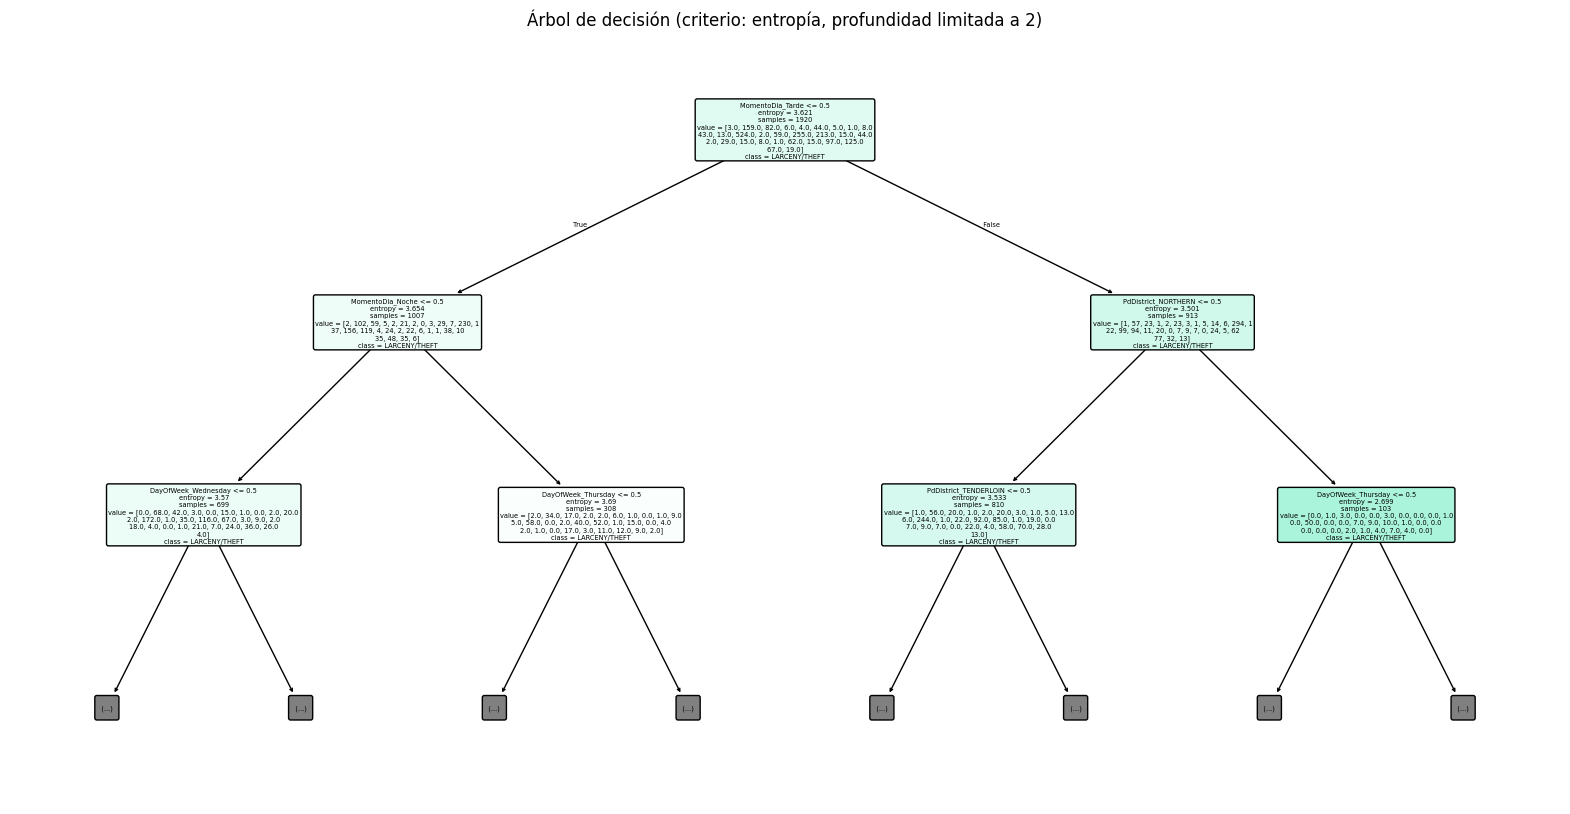

In [15]:
# Configurar el tamaño de la figura
plt.figure(figsize=(20, 10))

# Dibujar el árbol entrenado con entropía (modelo seleccionado)
plot_tree(
    modelo_entropy,
    feature_names=X_train.columns,
    class_names=modelo_entropy.classes_,
    filled=True,
    rounded=True,
    max_depth=2  # Mostrar solo hasta 2 niveles para que sea más legible
)

plt.title("Árbol de decisión (criterio: entropía, profundidad limitada a 2)")
plt.show()


### Visualización del modelo seleccionado (Árbol de decisión)

En este apartado se representa gráficamente el árbol de decisión entrenado con el criterio **entropía**, que fue seleccionado por ofrecer una precisión ligeramente superior en el apartado anterior.

Para facilitar su interpretación, se ha limitado la visualización del árbol a una **profundidad máxima de 2 niveles**. Esto permite observar las divisiones iniciales más relevantes sin saturar el gráfico con demasiada información.

#### ¿Qué información aparece en cada nodo del árbol?

Cada nodo del árbol muestra la siguiente información:

- **Condición** de división basada en una de las variables (`MomentoDia`, `DayOfWeek`, `PdDistrict`)
- **Samples**: número de registros que llegan a ese nodo
- **Value**: distribución de muestras por clase (número de registros por cada tipo de crimen)
- **Class**: clase más representativa en ese nodo (predicción si fuera hoja)

#### Interpretación del árbol (nivel 2):

- En el **nodo raíz**, el árbol realiza una primera división según una variable categórica transformada mediante one-hot encoding, como por ejemplo `PdDistrict_SOUTHERN`. Esto significa que se separan los crímenes en función de si ocurren o no en ese distrito.
- En el **segundo nivel**, aparecen divisiones por otras variables como el día de la semana (`DayOfWeek_Friday`) o el momento del día (`MomentoDia_Tarde`), indicando que estos factores también influyen en la predicción del tipo de crimen.

#### Nodo raíz del árbol

#### Explicación detallada:

- **Condición (`MomentoDia_Tarde <= 0.5`)**  
  Este nodo divide los datos en función de si el crimen ocurrió o no por la **tarde**. La variable `MomentoDia_Tarde` es binaria (creada con one-hot encoding):
  - Si vale `0`, el crimen ocurrió por la **noche o por la mañana**.
  - Si vale `1`, el crimen ocurrió por la **tarde**.  
  Por tanto:
  - La **rama izquierda** agrupa los crímenes ocurridos **fuera de la tarde**.
  - La **rama derecha** agrupa los crímenes ocurridos **por la tarde**.

- **Entropía (`entropy = 3.021`)**  
  Es una medida de impureza. Un valor cercano a 0 indica que casi todos los registros pertenecen a la misma clase. En este caso, el valor es alto (~3.0), lo que indica una gran **diversidad de clases** (tipos de crimen) en este nodo.

- **Samples (`samples = 1920`)**  
  Representa el número total de registros que han llegado a este nodo: todo el conjunto de entrenamiento.

- **Value (`value = [...]`)**  
  Esta lista representa la distribución de registros entre las diferentes clases. Cada número indica cuántos crímenes pertenecen a una clase concreta. Por ejemplo, `324.0` es el número de crímenes del tipo mayoritario.

- **Clase mayoritaria (`class = LARCENY/THEFT`)**  
  Aunque hay mucha diversidad, el tipo de crimen más frecuente en este nodo es `LARCENY/THEFT` (robo o hurto), por lo que esta sería la clase predicha si este nodo fuera una hoja.

#### Conclusión:

La primera división del árbol utiliza la variable `MomentoDia` para separar los datos, lo que indica que **el momento del día influye significativamente en el tipo de crimen**. Esta división inicial ya permite empezar a distinguir patrones, como que los hurtos tienden a ser los más comunes independientemente del horario.

El árbol comienza dividiendo por variables de distrito, lo que sugiere que la **zona donde ocurre el crimen es un factor clave**. Posteriormente, tiene en cuenta el momento del día y el día de la semana, lo que indica que hay patrones temporales asociados a ciertos delitos.



In [16]:

# Función para extraer reglas del árbol
def extraer_reglas(modelo, feature_names, class_names, max_depth=None):
    tree = modelo.tree_
    reglas = []

    def recorrer_nodo(nodo, regla_actual, profundidad):
        if max_depth is not None and profundidad > max_depth:
            return

        if tree.feature[nodo] != _tree.TREE_UNDEFINED:
            nombre_variable = feature_names[tree.feature[nodo]]
            umbral = tree.threshold[nodo]
            izquierda = tree.children_left[nodo]
            derecha = tree.children_right[nodo]

            recorrer_nodo(izquierda, regla_actual + [f"{nombre_variable} <= {umbral:.2f}"], profundidad + 1)
            recorrer_nodo(derecha, regla_actual + [f"{nombre_variable} > {umbral:.2f}"], profundidad + 1)
        else:
            muestras = tree.n_node_samples[nodo]
            clase = class_names[tree.value[nodo][0].argmax()]
            reglas.append((regla_actual, clase, muestras))

    recorrer_nodo(0, [], 1)
    return reglas

# Extraer reglas del modelo con entropía
reglas = extraer_reglas(modelo_entropy, X_train.columns, modelo_entropy.classes_)

# Ordenar reglas por número de muestras
reglas_ordenadas = sorted(reglas, key=lambda x: x[2])

# Seleccionar 3 reglas que generalizan poco (menos muestras) y 3 que generalizan mucho (más muestras)
especialistas = reglas_ordenadas[:3]
generalistas = reglas_ordenadas[-3:]

especialistas, generalistas


([(['MomentoDia_Tarde <= 0.50',
    'MomentoDia_Noche > 0.50',
    'DayOfWeek_Thursday <= 0.50',
    'DayOfWeek_Sunday <= 0.50',
    'PdDistrict_SOUTHERN <= 0.50',
    'DayOfWeek_Tuesday <= 0.50',
    'PdDistrict_MISSION <= 0.50',
    'PdDistrict_BAYVIEW <= 0.50',
    'DayOfWeek_Monday <= 0.50',
    'PdDistrict_PARK <= 0.50',
    'PdDistrict_TENDERLOIN <= 0.50',
    'PdDistrict_INGLESIDE <= 0.50',
    'DayOfWeek_Wednesday <= 0.50',
    'PdDistrict_CENTRAL <= 0.50',
    'DayOfWeek_Friday <= 0.50',
    'PdDistrict_NORTHERN <= 0.50',
    'PdDistrict_TARAVAL <= 0.50'],
   'BURGLARY',
   np.int64(1)),
  (['MomentoDia_Tarde <= 0.50',
    'MomentoDia_Noche > 0.50',
    'DayOfWeek_Thursday <= 0.50',
    'DayOfWeek_Sunday <= 0.50',
    'PdDistrict_SOUTHERN <= 0.50',
    'DayOfWeek_Tuesday <= 0.50',
    'PdDistrict_MISSION <= 0.50',
    'PdDistrict_BAYVIEW <= 0.50',
    'DayOfWeek_Monday <= 0.50',
    'PdDistrict_PARK > 0.50',
    'DayOfWeek_Wednesday <= 0.50',
    'DayOfWeek_Friday > 0.50'],
  

### Reglas que generalizan poco y reglas que generalizan mucho: análisis e interpretación

Uno de los aspectos más valiosos de los árboles de decisión es su capacidad para generar **reglas explícitas de clasificación**. Cada hoja del árbol puede entenderse como una regla lógica que agrupa a los datos que cumplen una serie de condiciones.

En este apartado se han extraído todas las reglas del árbol entrenado con el criterio de entropía. A continuación, se han identificado:

- Las **3 reglas más especializadas**, es decir, las que se aplican a solo **1 muestra del conjunto de entrenamiento**.
- Las **3 reglas más generalistas**, que se aplican a **más de 25 muestras cada una**.



#### ¿Por qué en todas las condiciones aparece `<= 0.5`?

Esto se debe a que las variables categóricas (como `MomentoDia`, `DayOfWeek` o `PdDistrict`) han sido transformadas mediante **One-Hot Encoding**. Este proceso convierte cada categoría en una columna binaria, que toma valor:

- `1` si se cumple esa categoría (por ejemplo, si el crimen ocurrió por la tarde, `MomentoDia_Tarde = 1`)
- `0` en caso contrario

Por tanto, una condición como `MomentoDia_Tarde <= 0.5` significa que **el crimen no ocurrió por la tarde**.  
Este tipo de comparación con `0.5` es la forma que tiene el árbol de decisión de dividir entre “sí pertenece a la categoría” (`> 0.5`) y “no pertenece” (`<= 0.5`). No es un error, sino una consecuencia lógica del tratamiento de variables categóricas en scikit-learn.



####  ¿Qué es una regla especializada?

Son aquellas reglas del árbol que clasifican una **única muestra**. Contienen una cadena de condiciones muy larga y precisa, por lo que apenas se aplican a nuevos datos. Estas reglas son el resultado de una **profunda ramificación del árbol** y muestran **sobreajuste** (overfitting).

##### Reglas especializadas extraídas:

1. **Predicción: `BURGLARY` (1 muestra)**  
   Condiciones:
   - No ocurre por la tarde (`MomentoDia_Tarde <= 0.5`)
   - Ocurre por la noche (`MomentoDia_Noche > 0.5`)
   - No ocurre en ninguno de los principales días (`Thursday`, `Sunday`, `Tuesday`, `Monday`, `Wednesday`, `Friday`)
   - No ocurre en los distritos más comunes (`SOUTHERN`, `MISSION`, `BAYVIEW`, `PARK`, `TENDERLOIN`, etc.)

   Esta combinación tan específica reduce la regla a un único caso. Refleja un **patrón atípico** y poco representativo.

2. **Predicción: `ASSAULT` (1 muestra)**  
   Similar a la anterior, pero cambia la condición final: el crimen ocurre en el **distrito PARK** y un **viernes**.  
   A pesar de que los delitos de agresión pueden ser comunes, esta configuración solo aparece una vez, lo que demuestra lo **estrecho de la regla**.

3. **Predicción: `LARCENY/THEFT` (1 muestra)**  
   Ocurre por la noche, un lunes, fuera de todos los principales distritos y días comunes.  
   A pesar de que `LARCENY/THEFT` es la clase más frecuente, aquí aparece bajo un patrón **muy concreto y aislado**.



####  ¿Qué es una regla generalista?

Las reglas generalistas son aquellas que se aplican a un número **significativo de ejemplos**, agrupando características comunes entre muchos registros. Estas reglas aparecen en las **primeras ramas del árbol** y ayudan a **modelar patrones frecuentes**.

##### Reglas generalistas extraídas:

1. **Predicción: `LARCENY/THEFT` (28 muestras)**  
   Condiciones:
   - El crimen ocurre por la tarde
   - Ocurre en el distrito `NORTHERN`
   - No ocurre un jueves, pero sí un miércoles  

   Esta regla representa un **patrón habitual** en el dataset: los robos suelen concentrarse en zonas con alta actividad comercial (como `NORTHERN`) durante la tarde, y se repiten en días laborables.

2. **Predicción: `LARCENY/THEFT` (31 muestras)**  
   El crimen ocurre por la tarde, no en `NORTHERN`, y sigue una secuencia de condiciones que descarta otros distritos hasta centrarse en `SOUTHERN`, con ocurrencia en sábado.  
   Esta regla agrupa un patrón común, aunque más complejo. Sigue siendo generalista por su capacidad de clasificar más de 30 casos.

3. **Predicción: `LARCENY/THEFT` (45 muestras)**  
   Muy similar a la anterior, pero enfocada en crímenes cometidos un **miércoles**. El patrón vuelve a repetirse con condiciones amplias dentro de zonas donde el robo es frecuente.



### Conclusión del análisis

- Las **reglas más especializadas** son útiles para detectar **casos raros o excepcionales**, pero no son fiables para generalizar. El modelo podría haberlas aprendido por azar o ruido en los datos. Representan un riesgo de **sobreajuste**.
- Las **reglas generalistas**, aunque menos detalladas, reflejan **tendencias consistentes** en el comportamiento criminal de la ciudad. Son las más útiles para la predicción y tienen mayor valor analítico.

En el caso de este dataset, se observa que la mayoría de reglas generalistas terminan prediciendo `LARCENY/THEFT`, lo que confirma que este tipo de crimen es **el más común** en el conjunto de datos. La diversidad en las reglas especializadas también evidencia que existen **casos atípicos** con características únicas.

Este tipo de análisis permite comprender cómo el árbol toma decisiones, y qué tan fiables o útiles pueden ser sus predicciones según el tipo de rama que se recorra.


In [17]:
# Crear un DataFrame con los tres escenarios a clasificar
escenarios = pd.DataFrame({
    'MomentoDia': ['Mañana', 'Noche', 'Mañana'],
    'DayOfWeek': ['Thursday', 'Saturday', 'Monday'],
    'PdDistrict': ['TARAVAL', 'PARK', 'CENTRAL']
})

# Aplicar one-hot encoding para que coincida con el modelo
X_escenarios = pd.get_dummies(escenarios)

# Asegurarse de que las columnas coincidan exactamente con las del modelo (agregar columnas faltantes con 0)
for col in X_train.columns:
    if col not in X_escenarios.columns:
        X_escenarios[col] = 0

# Ordenar las columnas en el mismo orden que X_train
X_escenarios = X_escenarios[X_train.columns]

# Realizar predicciones con el modelo entrenado
predicciones = modelo_entropy.predict(X_escenarios)

# Unir resultados con los escenarios originales
escenarios["Predicción de crimen"] = predicciones
escenarios


,MomentoDia,DayOfWeek,PdDistrict,Predicción de crimen
0,Mañana,Thursday,TARAVAL,NON-CRIMINAL
1,Noche,Saturday,PARK,ASSAULT
2,Mañana,Monday,CENTRAL,LARCENY/THEFT


### Clasificación de crímenes 

En este apartado se ha utilizado el **clasificador entrenado mediante un árbol de decisión** (con el criterio de entropía) para predecir el tipo de crimen más probable en **tres contextos reales** definidos por el enunciado.  
El objetivo es comprobar la capacidad del modelo para realizar predicciones sobre situaciones nuevas utilizando únicamente las tres variables disponibles: **momento del día**, **día de la semana** y **distrito**.

#### Proceso seguido:

1. Se ha construido un pequeño conjunto de prueba con tres combinaciones específicas que representan los escenarios planteados en la práctica.
2. Para que estos datos puedan ser usados por el modelo entrenado, se ha aplicado **One-Hot Encoding** a las variables categóricas, tal como se hizo en el preprocesamiento original.
3. Se ha verificado que las columnas del nuevo conjunto coincidan exactamente con las del entrenamiento para garantizar la compatibilidad.
4. Finalmente, se ha realizado la **predicción de clase** para cada caso con el clasificador ya entrenado.



#### Escenarios y predicciones obtenidas:

| Momento del día | Día de la semana | Distrito   | Predicción de crimen |
|-----------------|------------------|------------|-----------------------|
| Mañana          | Jueves           | TARAVAL    | NON-CRIMINAL          |
| Noche           | Sábado           | PARK       | ASSAULT               |
| Mañana          | Lunes            | CENTRAL    | LARCENY/THEFT         |



#### Interpretación de los resultados:

1. **Mañana de jueves en el distrito de TARAVAL → `NON-CRIMINAL`**  
   El modelo considera que este contexto tiene más probabilidad de corresponder a un caso **no delictivo**. Este resultado puede deberse a que, históricamente, en este distrito y franja horaria se registran más intervenciones policiales sin delito que crímenes propiamente dichos. Es un ejemplo interesante de cómo el modelo puede detectar patrones de comportamiento más administrativos que delictivos.

2. **Noche del sábado en el distrito de PARK → `ASSAULT`**  
   El modelo predice un crimen de tipo **agresión**. Esta predicción es coherente con las tendencias reales en muchas ciudades, donde las noches de fin de semana presentan un aumento en delitos relacionados con conflictos interpersonales, consumo de alcohol y altercados en la vía pública. PARK es, además, un distrito con vida nocturna activa.

3. **Lunes por la mañana en el distrito de CENTRAL → `LARCENY/THEFT`**  
   El centro urbano (`CENTRAL`) es una zona con alta densidad de comercios y oficinas. Los lunes por la mañana representan el inicio de la semana laboral, con mucho movimiento de personas. Por tanto, es lógico que el modelo prediga delitos como **robos o hurtos**, asociados a entornos con gran afluencia de público.



### Conclusión:

Este apartado demuestra la utilidad práctica del modelo entrenado: permite **anticipar el tipo de crimen más probable** en función de variables simples como el momento del día, el día de la semana y la localización.  
Estas predicciones no solo sirven como herramienta de análisis, sino que pueden ser valiosas para **planificar recursos policiales**, **reforzar la prevención** en determinadas franjas horarias o distritos y **generar alertas tempranas** ante posibles escenarios de riesgo.

El hecho de que el modelo identifique patrones coherentes y realistas en contextos distintos valida su diseño y refuerza su aplicabilidad en entornos urbanos como San Francisco.
